In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ERROR: Error in library(tidyverse): there is no package called 'tidyverse'


In [4]:
data <- read.csv("Earthquate_Damage.csv")
cat_cols <- c("land_surface_condition","foundation_type",
              "roof_type","ground_floor_type",
             "other_floor_type","position",
              "plan_configuration","legal_ownership_status")
install.packages("nnet")
library(nnet)
j <- 1
for(i in 1:length(cat_cols)){
    tmp <- class.ind(data[,cat_cols[i]])
    colnames(tmp) <- (j:(j+length(colnames(tmp)) - 1))
    data <- cbind(data,tmp)
    j <- (j+length(colnames(tmp)))
}
data <- data[,!(names(data)%in%cat_cols)]
scaled_data <- scale(data[,1:31],center=TRUE,scale=TRUE)
other_data <- data[,32:70]
data <- cbind(scaled_data,other_data)
rm(scaled_data)
rm(other_data)
set.seed(42)
trn_idx <- sample(1:nrow(data), 150000)
train <- data[trn_idx,]
tmp <- data[-trn_idx,]
val_idx <- sample(1:nrow(tmp),50000)
val <- tmp[val_idx,]
test <- tmp[-val_idx,]
rm(trn_idx)
rm(tmp)
rm(val_idx)
perf_eval_multi <- function(cm){
  
  # Simple Accuracy
  ACC = sum(diag(cm))/sum(cm)
  
  # Balanced Correction Rate
  BCR = 1
  for (i in 1:dim(cm)[1]){
    BCR = BCR*(cm[i,i]/sum(cm[i,])) 
  }
  
  BCR = BCR^(1/dim(cm)[1])
  
  return(c(ACC, BCR))
}
prediction_one <- function(pred){
    tmp <- apply(pred,1,which.max)
    for (i in 1:nrow(pred)){
        pred[i,tmp[i]] <- 1
        pred[i,-tmp[i]] <- 0
    }
    return(pred)
}
library(party)
all_train <- rbind(train,val)

package 'nnet' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\lmwlm\AppData\Local\Temp\RtmpeudPyh\downloaded_packages


Loading required package: grid

Loading required package: mvtnorm

Loading required package: modeltools

Loading required package: stats4

Loading required package: strucchange

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: sandwich



In [5]:
val$damage_grade <- as.factor(val$damage_grade)
train$damage_grade <- as.factor(train$damage_grade)
all_train$damage_grade <- as.factor(all_train$damage_grade)
test$damage_grade <- as.factor(test$damage_grade)

In [6]:
max_depth <- c(5,7,10)
min_split <- c(10,100,1000)
ctree_pre_search_result = matrix(0,length(min_split)*length(max_depth),4)
colnames(ctree_pre_search_result) <- c("min_split", "max_depth","ACC", "BCR")

In [7]:
iter_cnt = 1
for ( i in 1:length(min_split)){
    for ( j in 1:length(max_depth)){
        tmp_control <- ctree_control(maxdepth = max_depth[j], minsplit = min_split[i])
        tmp_ctree_model <- ctree( damage_grade~ ., data = train,control = tmp_control)
        tmp_pred <- predict(tmp_ctree_model, val)
        tmp_ctree_val_cm <- table(val$damage_grade, tmp_pred)
        ctree_pre_search_result[iter_cnt,3:4] = perf_eval_multi(tmp_ctree_val_cm)
        ctree_pre_search_result[iter_cnt,1] = min_split[i]
        ctree_pre_search_result[iter_cnt,2] = max_depth[j]
        iter_cnt = iter_cnt+1

    }
}

In [8]:
ctree_pre_search_result

min_split,max_depth,ACC,BCR
10,5,0.59040,0.3705786
10,7,0.63788,0.4898993
10,10,0.66092,0.5206601
100,5,0.59040,0.3705786
100,7,0.63786,0.4898986
100,10,0.66100,0.5204497
1000,5,0.58986,0.3698707
1000,7,0.63618,0.4958848
1000,10,0.65722,0.5234024


In [10]:
tmp_control <- ctree_control(maxdepth = 10, minsplit = 100)
tmp_ctree_model <- ctree( damage_grade~ ., data = all_train,control = tmp_control)
tmp_pred <- predict(tmp_ctree_model, test)
tmp_ctree_test_cm <- table(test$damage_grade, tmp_pred)
perf_eval_multi(tmp_ctree_test_cm)

[1] 0.6595436 0.5214040

In [95]:
ctree_boots <- function(seed){
    set.seed(seed)
    boots_idx <- sample(1:nrow(all_train),20000,replace=TRUE)
    tmp_train <- all_train[boots_idx,]
    tmp_control <- ctree_control(maxdepth = 10, minsplit = 100)
    tmp_cart_model <- ctree(damage_grade~ ., data = tmp_train,controls = tmp_control)
    tmp_pred <- predict(tmp_ctree_model, test)
    
    return(tmp_pred)
}

In [96]:
boots_result <- matrix(0,nrow(test),300)

In [97]:
iters_cnt <- 1
for (i in 1:300){
    boots_result[,iters_cnt] <- ctree_boots(i)
    iters_cnt <- iters_cnt + 1
}

In [98]:
ncol(boots_result)

[1] 300

In [99]:
getmode <- function(v) {
   uniqv <- unique(v)
   return(uniqv[which.max(tabulate(match(v, uniqv)))])
}

In [100]:
 result <- c(rep(0,times=nrow(x_test)))

In [101]:
perf_ctree_bagging <- matrix(0,10,3)
colnames(perf_ctree_bagging) <- c("bootstrap_num","ACC", "BCR")

In [103]:
iters_cnt <- 1
for (i in 1:10){
    for (j in 1:length(result)){
        result[j] <- getmode(boots_result[j,(1:(i*30))])
    }
    tmp_cm <- table(test$damage_grade, result)
    perf_ctree_bagging[iters_cnt,1] <- i*30
    perf_ctree_bagging[iters_cnt,2:3] <- perf_eval_multi(tmp_cm)
    iters_cnt <- iters_cnt+1
}

In [104]:
perf_ctree_bagging

bootstrap_num,ACC,BCR
30,0.6579759,0.5191223
60,0.6579759,0.5191223
90,0.6579759,0.5191223
120,0.6579759,0.5191223
150,0.6579759,0.5191223
180,0.6579759,0.5191223
210,0.6579759,0.5191223
240,0.6579759,0.5191223
270,0.6579759,0.5191223
300,0.6579759,0.5191223


In [13]:
rf_cart <- matrix(0,10,5)
colnames(rf_cart) <- c("bootstrap_num","ACC-cart","ACC-rf", "BCR-cart","BCR-rf")

In [14]:
rf_cart[1:10,1] <- c(30,60,90,120,150,180,210,240,270,300)
rf_cart[1:10,2] <- c(0.6579759,0.6579759,0.6579759,0.6579759,0.6579759,0.6579759,0.6579759,0.6579759,0.6579759,0.6579759)
rf_cart[1:10,3] <- c(0.7072326,0.7116549,0.7104668,0.7121830,0.7132556,0.7122985,0.7129255,0.7134371,0.7136021,0.7139981)
rf_cart[1:10,4] <- c(0.5191223,0.5191223,0.5191223,0.5191223,0.5191223,0.5191223,0.5191223,0.5191223,0.5191223,0.5191223)
rf_cart[1:10,5] <- c(0.5766060,0.5748111,0.5744820,0.5776896,0.5797089,0.5763037,0.5775153,0.5775716,0.5787192,0.5780241)

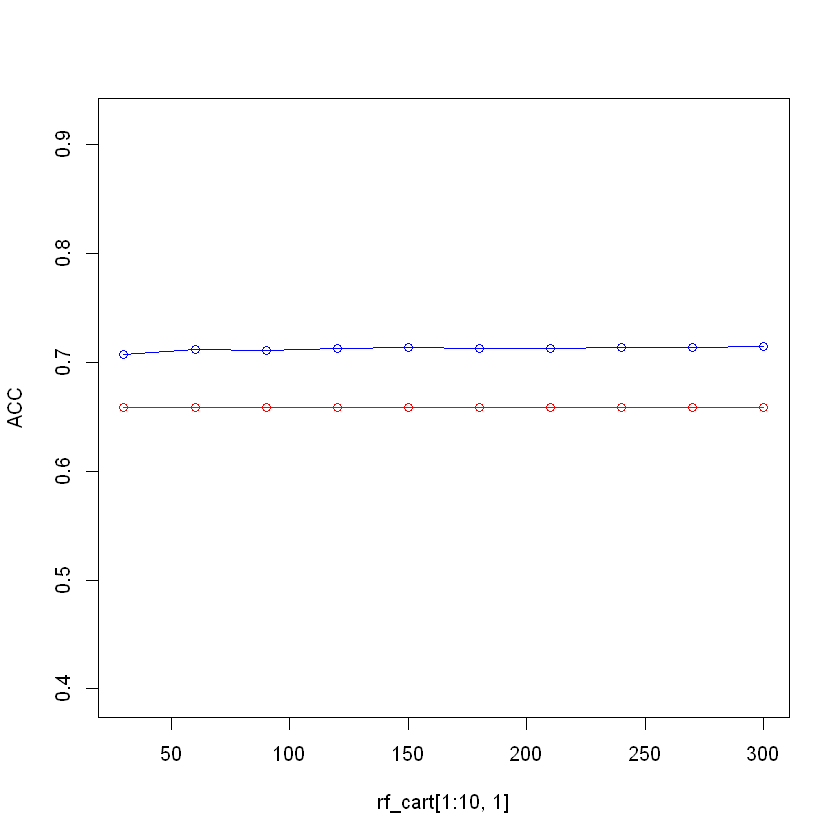

In [17]:
plot(rf_cart[1:10,1],rf_cart[1:10,2],type='o',col=2,ylab="ACC") #col=2: 빨간색
lines(rf_cart[1:10,1],rf_cart[1:10,3],type='o',col=4)               #col=4: 파란색
legend(1,40,c("ACC-cart","ACC-rf"),lwd=c(1,1),col=c("red","blue"))

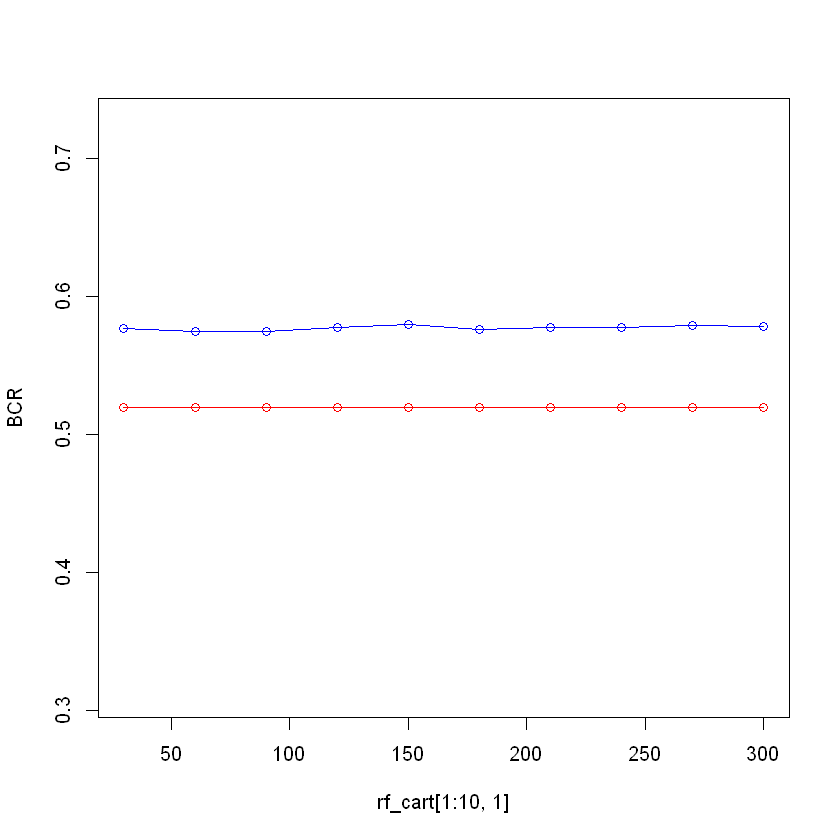

In [18]:
plot(rf_cart[1:10,1],rf_cart[1:10,4],type='o',col=2,ylab="BCR") #col=2: 빨간색
lines(rf_cart[1:10,1],rf_cart[1:10,5],type='o',col=4)               #col=4: 파란색
legend(1,40,c("BCR-cart","BCR-rf"),lwd=c(1,1),col=c("red","blue"))